In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download kapillondhe/american-sign-language

100% 4.62G/4.64G [00:54<00:00, 131MB/s]
100% 4.64G/4.64G [00:54<00:00, 91.0MB/s]


In [7]:
!unzip american-sign-language.zip

Streaming output truncated to the last 5000 lines.
  inflating: ASL_Dataset/Train/Z/1897.jpg  
  inflating: ASL_Dataset/Train/Z/1898.jpg  
  inflating: ASL_Dataset/Train/Z/1899.jpg  
  inflating: ASL_Dataset/Train/Z/19.jpg  
  inflating: ASL_Dataset/Train/Z/190.jpg  
  inflating: ASL_Dataset/Train/Z/1900.jpg  
  inflating: ASL_Dataset/Train/Z/1901.jpg  
  inflating: ASL_Dataset/Train/Z/1902.jpg  
  inflating: ASL_Dataset/Train/Z/1903.jpg  
  inflating: ASL_Dataset/Train/Z/1904.jpg  
  inflating: ASL_Dataset/Train/Z/1905.jpg  
  inflating: ASL_Dataset/Train/Z/1906.jpg  
  inflating: ASL_Dataset/Train/Z/1907.jpg  
  inflating: ASL_Dataset/Train/Z/1908.jpg  
  inflating: ASL_Dataset/Train/Z/1909.jpg  
  inflating: ASL_Dataset/Train/Z/191.jpg  
  inflating: ASL_Dataset/Train/Z/1910.jpg  
  inflating: ASL_Dataset/Train/Z/1911.jpg  
  inflating: ASL_Dataset/Train/Z/1912.jpg  
  inflating: ASL_Dataset/Train/Z/1913.jpg  
  inflating: ASL_Dataset/Train/Z/1914.jpg  
  inflating: ASL_Dataset/Trai

In [12]:
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.layers as layers

In [9]:
def load_images():
    image_size = (299, 299)
    batch_size = 32

    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "ASL_Dataset/Train",
        validation_split=0.2,
        subset="training",
        seed=1337,
        image_size=image_size,
        batch_size=batch_size,
    )
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "ASL_Dataset/Train",
        validation_split=0.2,
        subset="validation",
        seed=1337,
        image_size=image_size,
        batch_size=batch_size,
    )
    return train_ds, val_ds
train_ds, val_ds = load_images()

Found 165670 files belonging to 28 classes.
Using 132536 files for training.
Found 165670 files belonging to 28 classes.
Using 33134 files for validation.


In [28]:
classes = train_ds.class_names

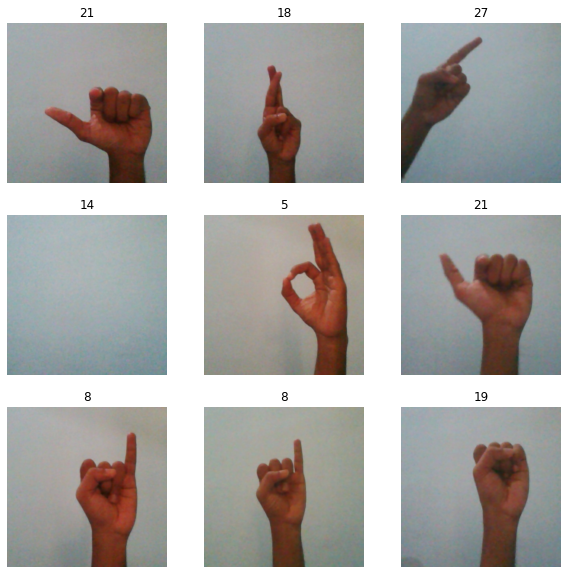

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [13]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(400,
                                  400,
                                  3)),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
  ]
)

In [17]:
def train_model():
    base_model = tf.keras.applications.InceptionV3(
                    include_top=False,
                    weights="imagenet",
                    input_shape=(299, 299, 3),
                    classifier_activation="softmax",
                )
    base_model.trainable = False

    x = base_model.output
    # x = data_augmentation()
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(1024, activation="relu")(x)
    
    outputs = keras.layers.Dense(200, activation='softmax')(x)
    
    model = keras.Model(inputs=base_model.input, outputs=outputs)
    
    model.compile(optimizer = keras.optimizers.SGD(learning_rate=0.0001,momentum=0.9),
                    loss = "sparse_categorical_crossentropy",
                    metrics = ["accuracy"])
    model = model.fit(train_ds, epochs=5,validation_data=val_ds)

    return model
    
model = train_model()

Epoch 1/5
4142/4142 [==============================] - 686s 165ms/step - loss: 0.6660 - accuracy: 0.8628 - val_loss: 0.1916 - val_accuracy: 0.9402
Epoch 2/5
4142/4142 [==============================] - 674s 163ms/step - loss: 0.1198 - accuracy: 0.9670 - val_loss: 0.0777 - val_accuracy: 0.9810
Epoch 3/5
4142/4142 [==============================] - 678s 164ms/step - loss: 0.0723 - accuracy: 0.9815 - val_loss: 0.0661 - val_accuracy: 0.9808
Epoch 4/5
4142/4142 [==============================] - 677s 163ms/step - loss: 0.0515 - accuracy: 0.9875 - val_loss: 0.0525 - val_accuracy: 0.9855
Epoch 5/5
4142/4142 [==============================] - 677s 163ms/step - loss: 0.0400 - accuracy: 0.9906 - val_loss: 0.0329 - val_accuracy: 0.9933


In [18]:
model.model.save("inception_model.h5")

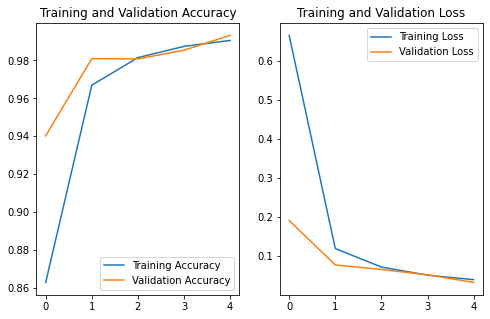

In [33]:
acc = model.history['accuracy']
val_acc = model.history['val_accuracy']

loss = model.history['loss']
val_loss = model.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig("validation score.jpg")
plt.show()

In [26]:
def predict_model(image_path):
  img = tf.keras.utils.load_img(
      image_path, target_size=(299, 299)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  return score

In [31]:
import os
import numpy as np
main_path = 'ASL_Dataset/Test'
y_pred = []
y_label = []
for label in os.listdir(main_path):
  parent_path = os.path.join(main_path, label)
  for image in os.listdir(parent_path):
    image_path = os.path.join(parent_path, image)
    score = predict_model(image_path)
    y_pred.append(classes[np.argmax(score)])
    y_label.append(label)
    print(
      "Predicted Label: {} with a {:.2f} percent confidence, Actual Label: {}"
      .format(classes[np.argmax(score)], np.max(score), label)
    )

Predicted Label: G with a 0.01 percent confidence, Actual Label: G
Predicted Label: G with a 0.01 percent confidence, Actual Label: G
Predicted Label: G with a 0.01 percent confidence, Actual Label: G
Predicted Label: G with a 0.01 percent confidence, Actual Label: G
Predicted Label: K with a 0.01 percent confidence, Actual Label: K
Predicted Label: K with a 0.01 percent confidence, Actual Label: K
Predicted Label: K with a 0.01 percent confidence, Actual Label: K
Predicted Label: K with a 0.01 percent confidence, Actual Label: K
Predicted Label: Z with a 0.01 percent confidence, Actual Label: Z
Predicted Label: Z with a 0.01 percent confidence, Actual Label: Z
Predicted Label: Z with a 0.01 percent confidence, Actual Label: Z
Predicted Label: Z with a 0.01 percent confidence, Actual Label: Z
Predicted Label: A with a 0.01 percent confidence, Actual Label: A
Predicted Label: A with a 0.01 percent confidence, Actual Label: A
Predicted Label: A with a 0.01 percent confidence, Actual Labe